# Assignment 7

## Support Vector Classifiers and Machines
Author: Samuel Fredric Berg

Student ID: sb224sc

Date: 2026-02-22

Course: Machine Learning 4DT905

### Conceptual

1. **SVMs** goal is to create a hyperplane which seperates classes which tries to maximize the margin to the closest point in each class. If a hyperpalane cannot be created, either a slack variable is introduced or a dimensionality increase is preformed, which makes it easier to make a hyperplane. 

2. Generally **SVMs** are robust to overfitting, however noisy data can cause overfitting. Certain kernels such as the *RBF* kernal can be more precise than *linear* kernals, but they are also more prone to overfitting. Small $C$ values allows for more misclassifications, which reduces the risk of overfitting.

### Practical

#### Imports

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

import warnings

warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")

#### Step 1: Generate data and get an overview

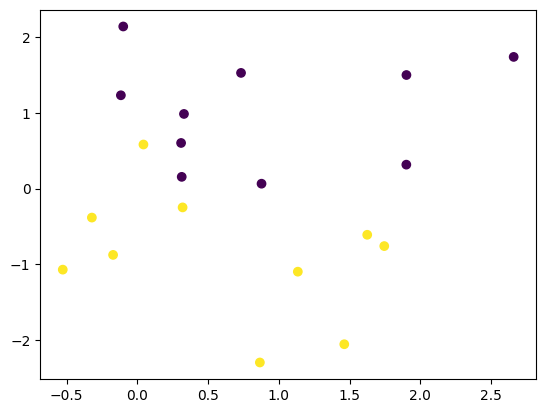

[[ 1.62434536 -0.61175641]
 [-0.52817175 -1.07296862]
 [ 0.86540763 -2.3015387 ]
 [ 1.74481176 -0.7612069 ]
 [ 0.3190391  -0.24937038]
 [ 1.46210794 -2.06014071]
 [-0.3224172  -0.38405435]
 [ 1.13376944 -1.09989127]
 [-0.17242821 -0.87785842]
 [ 0.04221375  0.58281521]
 [-0.10061918  2.14472371]
 [ 1.90159072  1.50249434]
 [ 1.90085595  0.31627214]
 [ 0.87710977  0.06423057]
 [ 0.73211192  1.53035547]
 [ 0.30833925  0.60324647]
 [ 0.3128273   0.15479436]
 [ 0.32875387  0.9873354 ]
 [-0.11731035  1.2344157 ]
 [ 2.65980218  1.74204416]]
[-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.]


In [48]:
np.random.seed(1)
X = np.random.randn(20, 2)
Y = np.concatenate([-np.ones(10), np.ones(10)])
X[Y == 1] += 1

plt.scatter(X[:, 0], X[:, 1], c=(3 - Y))
plt.show()

print(X)
print(Y)

          X1        X2  Y
0   1.624345 -0.611756 -1
1  -0.528172 -1.072969 -1
2   0.865408 -2.301539 -1
3   1.744812 -0.761207 -1
4   0.319039 -0.249370 -1
5   1.462108 -2.060141 -1
6  -0.322417 -0.384054 -1
7   1.133769 -1.099891 -1
8  -0.172428 -0.877858 -1
9   0.042214  0.582815 -1
10 -0.100619  2.144724  1
11  1.901591  1.502494  1
12  1.900856  0.316272  1
13  0.877110  0.064231  1
14  0.732112  1.530355  1
15  0.308339  0.603246  1
16  0.312827  0.154794  1
17  0.328754  0.987335  1
18 -0.117310  1.234416  1
19  2.659802  1.742044  1


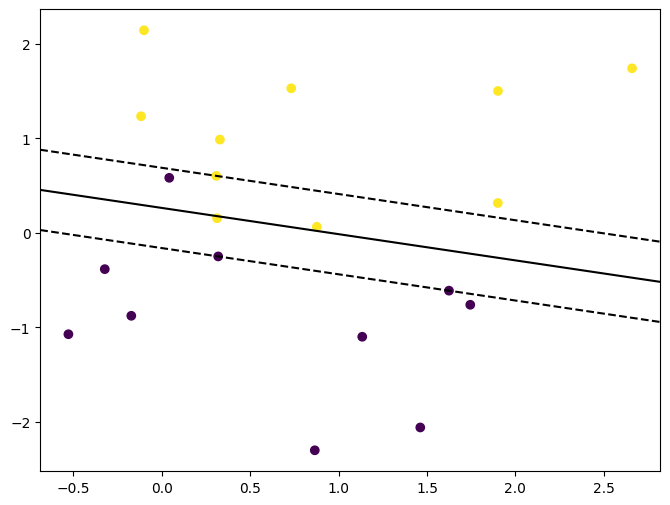

In [49]:
df = pd.DataFrame({"X1": X[:, 0], "X2": X[:, 1], "Y": Y.astype(int)})
print(df)

svm = SVC(kernel="linear", C=10)
svm.fit(df[["X1", "X2"]], df["Y"])

plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=Y)

ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

XX, YY = np.meshgrid(
    np.linspace(xlim[0], xlim[1], 50), np.linspace(ylim[0], ylim[1], 50)
)
XY = np.c_[XX.ravel(), YY.ravel()]
Z = svm.decision_function(XY).reshape(XX.shape)

ax.contour(
    XX,
    YY,
    Z,
    levels=[-1, 0, 1],
    linestyles=["dashed", "solid", "dashed"],
    colors="black",
)

plt.show()

In [50]:
support_vector_indices = svm.support_
print(support_vector_indices)

[ 0  4  9 13 15 16]


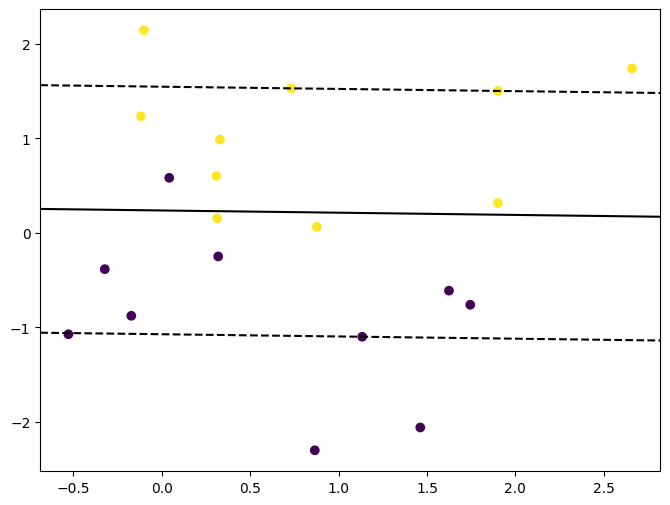

In [51]:
svm = SVC(kernel="linear", C=0.1)
svm.fit(df[["X1", "X2"]], df["Y"])

plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=Y)

ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

XX, YY = np.meshgrid(
    np.linspace(xlim[0], xlim[1], 50), np.linspace(ylim[0], ylim[1], 50)
)
XY = np.c_[XX.ravel(), YY.ravel()]
Z = svm.decision_function(XY).reshape(XX.shape)

ax.contour(
    XX,
    YY,
    Z,
    levels=[-1, 0, 1],
    linestyles=["dashed", "solid", "dashed"],
    colors="black",
)

plt.show()

**Interpretation:** 

The smaller $C$ value allows for wider area if error but also reduces risk of overfitting.

In [52]:
param_grid = {"C": [0.001, 0.01, 0.1, 1, 5, 10, 100]}

grid_search = GridSearchCV(SVC(kernel="linear"), param_grid, cv=10)
grid_search.fit(df[["X1", "X2"]], df["Y"])

cv_results = pd.DataFrame(grid_search.cv_results_)[
    ["param_C", "mean_test_score", "std_test_score"]
]
print(cv_results)

print("\nBest C:", grid_search.best_params_["C"])
print("Best Accuracy:", grid_search.best_score_)

   param_C  mean_test_score  std_test_score
0    0.001             0.95        0.150000
1    0.010             0.95        0.150000
2    0.100             0.85        0.229129
3    1.000             0.90        0.200000
4    5.000             0.90        0.200000
5   10.000             0.90        0.200000
6  100.000             0.90        0.200000

Best C: 0.001
Best Accuracy: 0.95


**Interpretation:** 

With $C=0.01$ we get a $95\%$ accuracy.

In [53]:
np.random.seed(1)
svm = SVC(kernel="linear", C=0.001)
svm.fit(df[["X1", "X2"]], df["Y"])
X_test = np.random.randn(20, 2)
Y_test = np.random.choice([-1, 1], size=20, replace=True)
X_test[Y_test == 1] += 1

Y_pred = svm.predict(X_test)
conf_matrix = confusion_matrix(Y_test, Y_pred)
print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 [[7 4]
 [1 8]]


**Interpretation:** 

With the newly generated data the accuracy is calculated to $75\%$.

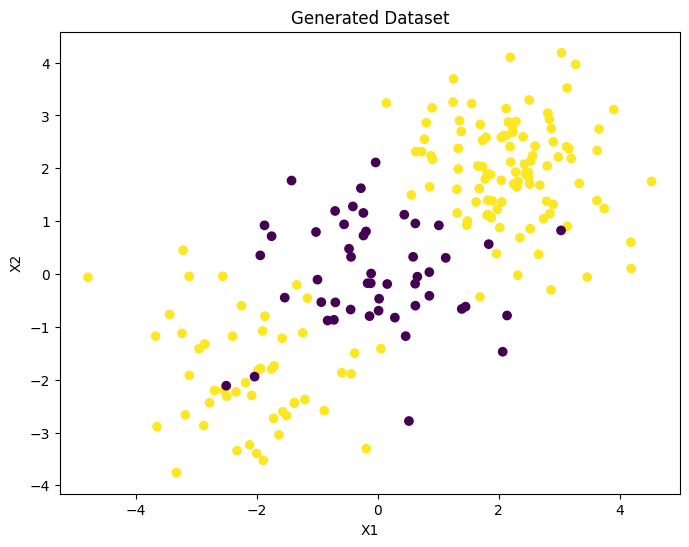

[[ 3.62434536  1.38824359]
 [ 1.47182825  0.92703138]
 [ 2.86540763 -0.3015387 ]
 [ 3.74481176  1.2387931 ]
 [ 2.3190391   1.75062962]
 [ 3.46210794 -0.06014071]
 [ 1.6775828   1.61594565]
 [ 3.13376944  0.90010873]
 [ 1.82757179  1.12214158]
 [ 2.04221375  2.58281521]
 [ 0.89938082  3.14472371]
 [ 2.90159072  2.50249434]
 [ 2.90085595  1.31627214]
 [ 1.87710977  1.06423057]
 [ 1.73211192  2.53035547]
 [ 1.30833925  1.60324647]
 [ 1.3128273   1.15479436]
 [ 1.32875387  1.9873354 ]
 [ 0.88268965  2.2344157 ]
 [ 3.65980218  2.74204416]
 [ 1.80816445  1.11237104]
 [ 1.25284171  3.6924546 ]
 [ 2.05080775  1.36300435]
 [ 2.19091548  4.10025514]
 [ 2.12015895  2.61720311]
 [ 2.30017032  1.64775015]
 [ 0.8574818   1.65065728]
 [ 1.79110577  2.58662319]
 [ 2.83898341  2.93110208]
 [ 2.28558733  2.88514116]
 [ 1.24560206  3.25286816]
 [ 2.51292982  1.70190716]
 [ 2.48851815  1.92442829]
 [ 3.13162939  3.51981682]
 [ 4.18557541  0.60350366]
 [ 0.55588619  1.49553414]
 [ 2.16003707  2.87616892]
 

In [54]:
np.random.seed(1)
X = np.random.randn(200, 2)
X[:100] += 2
X[100:150] -= 2
Y = np.concatenate([-np.ones(150), np.ones(50)])
df = pd.DataFrame({"X1": X[:, 0], "X2": X[:, 1], "Y": Y.astype(int)})

plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=(3 - Y), cmap="viridis")
plt.xlabel("X1")
plt.ylabel("X2")
plt.title("Generated Dataset")
plt.show()

print(X)
print(Y)

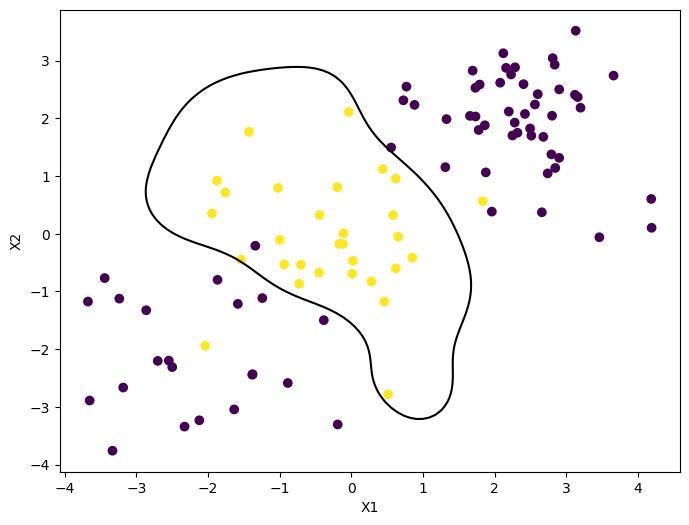

In [55]:
np.random.seed(1)
train_indices = np.random.choice(200, 100, replace=False)

train_data = df.iloc[train_indices]
test_data = df.drop(train_indices)

svmfit = SVC(kernel="rbf", gamma=1, C=1)
svmfit.fit(train_data[["X1", "X2"]], train_data["Y"])

plt.figure(figsize=(8, 6))
plt.scatter(train_data["X1"], train_data["X2"], c=train_data["Y"])
xlim, ylim = plt.xlim(), plt.ylim()
XX, YY = np.meshgrid(
    np.linspace(xlim[0], xlim[1], 100), np.linspace(ylim[0], ylim[1], 100)
)
XY = np.c_[XX.ravel(), YY.ravel()]
Z = svmfit.decision_function(XY).reshape(XX.shape)

plt.contour(XX, YY, Z, levels=[0], linestyles=["solid"], colors="black")

plt.xlabel("X1")
plt.ylabel("X2")
plt.show()

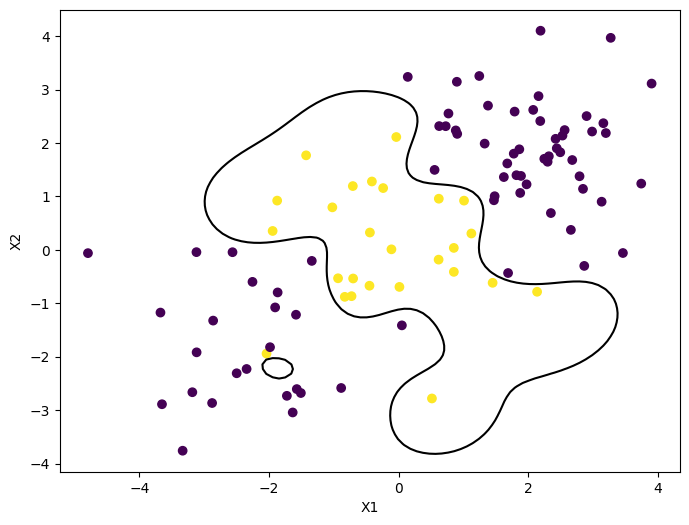

In [56]:
train_indices = np.random.choice(200, 100, replace=False)

train_data = df.iloc[train_indices]
test_data = df.drop(train_indices)

svmfit = SVC(kernel="rbf", gamma=1, C=100)
svmfit.fit(train_data[["X1", "X2"]], train_data["Y"])

plt.figure(figsize=(8, 6))
plt.scatter(train_data["X1"], train_data["X2"], c=train_data["Y"])
xlim, ylim = plt.xlim(), plt.ylim()
XX, YY = np.meshgrid(
    np.linspace(xlim[0], xlim[1], 100), np.linspace(ylim[0], ylim[1], 100)
)
XY = np.c_[XX.ravel(), YY.ravel()]
Z = svmfit.decision_function(XY).reshape(XX.shape)

plt.contour(XX, YY, Z, levels=[0], linestyles=["solid"], colors="black")

plt.xlabel("X1")
plt.ylabel("X2")
plt.show()

In [57]:
param_grid = {"C": [0.1, 1, 10, 100, 1000], "gamma": [0.5, 1]}

grid_search = GridSearchCV(SVC(kernel="rbf"), param_grid, cv=10)
grid_search.fit(df[["X1", "X2"]], df["Y"])

cv_results = pd.DataFrame(grid_search.cv_results_)[
    ["param_C", "param_gamma", "mean_test_score", "std_test_score"]
]
print(cv_results)

print("\nBest C:", grid_search.best_params_["C"])
print("Best Gamma:", grid_search.best_params_["gamma"])
print(f"Best Accuracy: {grid_search.best_score_:.2f}")

   param_C  param_gamma  mean_test_score  std_test_score
0      0.1          0.5            0.905        0.065000
1      0.1          1.0            0.865        0.063443
2      1.0          0.5            0.940        0.043589
3      1.0          1.0            0.940        0.043589
4     10.0          0.5            0.920        0.045826
5     10.0          1.0            0.920        0.033166
6    100.0          0.5            0.900        0.038730
7    100.0          1.0            0.880        0.090000
8   1000.0          0.5            0.870        0.122882
9   1000.0          1.0            0.865        0.118427

Best C: 1
Best Gamma: 0.5
Best Accuracy: 0.94


**Interpretation:** 

Now we get an accuracy of $94\%$ with $C=1$ and a gamma of $0.5$.

In [58]:
svm = SVC(kernel="rbf", C=1, gamma=0.5)
svm.fit(df[["X1", "X2"]], df["Y"])

X_test = np.random.randn(100, 2)
X_test[:50] += 2
X_test[50:75] -= 2
Y_test = np.concatenate([-np.ones(75), np.ones(25)])

Y_pred = svm.predict(X_test)
conf_matrix = confusion_matrix(Y_test, Y_pred)
print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 [[71  4]
 [ 3 22]]


**Interpretation:** 

With the test data we get an accuracy of $93\%$.

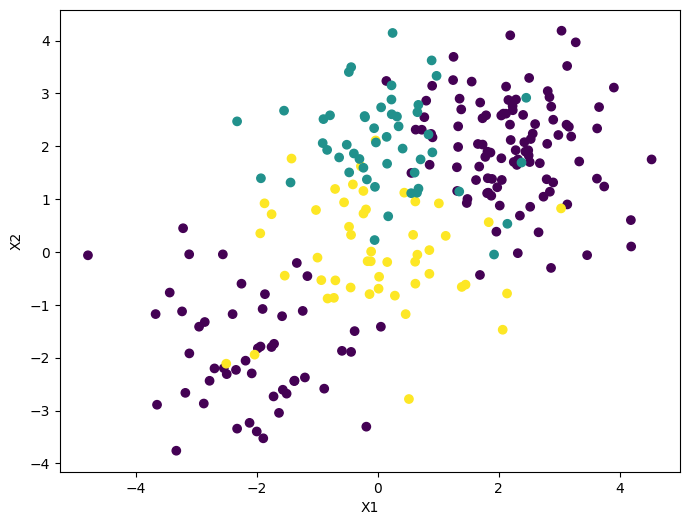

           X1        X2    Y
0    3.624345  1.388244 -1.0
1    1.471828  0.927031 -1.0
2    2.865408 -0.301539 -1.0
3    3.744812  1.238793 -1.0
4    2.319039  1.750630 -1.0
..        ...       ...  ...
245  1.347264  1.144185  0.0
246 -0.910924  2.060662  0.0
247  0.707985  1.752115  0.0
248 -0.472958  1.505882  0.0
249 -0.303401  1.760157  0.0

[250 rows x 3 columns]


In [60]:
X = np.vstack([X, np.random.randn(50, 2)])
Y = np.concatenate([Y, np.zeros(50)])

X[Y == 0, 1] += 2

df = pd.DataFrame({"X1": X[:, 0], "X2": X[:, 1], "Y": Y})

plt.figure(figsize=(8, 6))
plt.scatter(df["X1"], df["X2"], c=df["Y"])
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()

print(df)

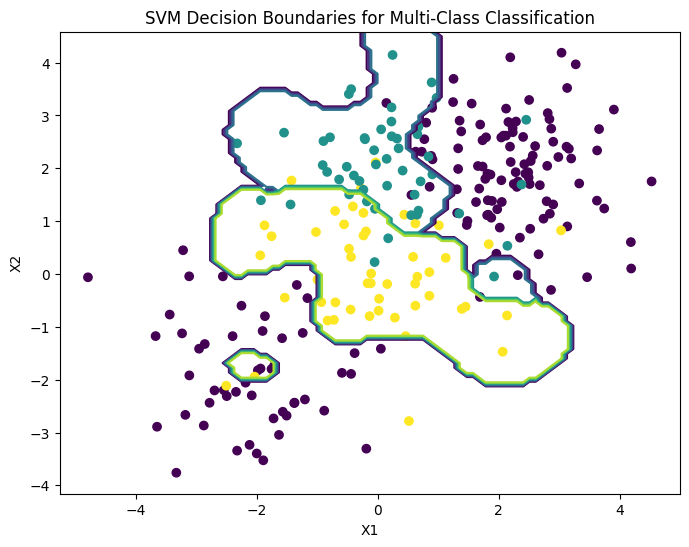

In [61]:
np.random.seed(1)
train_indices = np.random.choice(250, 125, replace=False)

train_data = df.iloc[train_indices]
test_data = df.drop(train_indices)

svm = SVC(kernel="rbf", C=10, gamma=1)
svm.fit(train_data[["X1", "X2"]], train_data["Y"])

plt.figure(figsize=(8, 6))
plt.scatter(df["X1"], df["X2"], c=df["Y"])

xlim, ylim = plt.xlim(), plt.ylim()
XX, YY = np.meshgrid(
    np.linspace(xlim[0], xlim[1], 100), np.linspace(ylim[0], ylim[1], 100)
)

XY = np.c_[XX.ravel(), YY.ravel()]
Z = svm.predict(XY)
Z = Z.reshape(XX.shape)

plt.contour(XX, YY, Z)
plt.xlabel("X1")
plt.ylabel("X2")
plt.title("SVM Decision Boundaries for Multi-Class Classification")
plt.show()

In [62]:
param_grid = {"C": [0.1, 1, 10, 100, 1000], "gamma": [0.5, 1, 2, 3, 4]}

grid_search = GridSearchCV(SVC(kernel="rbf"), param_grid, cv=10)
grid_search.fit(df[["X1", "X2"]], df["Y"])

cv_results = pd.DataFrame(grid_search.cv_results_)[
    ["param_C", "param_gamma", "mean_test_score", "std_test_score"]
]
print(cv_results)

print("\nBest C:", grid_search.best_params_["C"])
print("Best Gamma:", grid_search.best_params_["gamma"])
print(f"Best Accuracy: {grid_search.best_score_:.2f}")

    param_C  param_gamma  mean_test_score  std_test_score
0       0.1          0.5            0.808    4.995998e-02
1       0.1          1.0            0.772    3.124100e-02
2       0.1          2.0            0.648    4.308132e-02
3       0.1          3.0            0.600    1.110223e-16
4       0.1          4.0            0.600    1.110223e-16
5       1.0          0.5            0.852    4.019950e-02
6       1.0          1.0            0.856    4.079216e-02
7       1.0          2.0            0.836    4.543127e-02
8       1.0          3.0            0.828    4.019950e-02
9       1.0          4.0            0.832    3.487119e-02
10     10.0          0.5            0.848    2.400000e-02
11     10.0          1.0            0.832    4.308132e-02
12     10.0          2.0            0.808    5.878775e-02
13     10.0          3.0            0.792    6.881860e-02
14     10.0          4.0            0.768    8.908423e-02
15    100.0          0.5            0.812    7.166589e-02
16    100.0   

In [63]:
svm = SVC(kernel="rbf", C=1, gamma=0.5)
svm.fit(train_data[["X1", "X2"]], train_data["Y"])
Y_pred = svm.predict(test_data[["X1", "X2"]])
cm = confusion_matrix(test_data["Y"], Y_pred)
print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 [[71  4]
 [ 3 22]]


**Interpretation:** 

Here we get the same accuracy of $93\%$.

#### Load data

In [66]:
X_train = pd.read_csv("../data/Khan_xtrain.csv", index_col=0)
X_test = pd.read_csv("../data/Khan_xtest.csv", index_col=0)
Y_train = pd.read_csv("../data/Khan_ytrain.csv", index_col=0)
Y_test = pd.read_csv("../data/Khan_ytest.csv", index_col=0)

print(len(X_train), len(X_train.columns.tolist()))
print(len(X_test), len(X_test.columns.tolist()))

63 2308
20 2308


In [67]:
Y_train = Y_train.iloc[:, 0]

svm_model = SVC(kernel="linear", C=10)
svm_model.fit(X_train, Y_train)

print("Number of Support:", svm_model.n_support_)
print("Number of classes:", svm_model.classes_)

Number of Support: [ 7 18  9 20]
Number of classes: [1 2 3 4]


In [68]:
Y_train_pred = svm_model.predict(X_train)
conf_matrix = confusion_matrix(Y_train, Y_train_pred)
conf_matrix_df = pd.DataFrame(
    conf_matrix, index=svm_model.classes_, columns=svm_model.classes_
)

print(conf_matrix_df)

   1   2   3   4
1  8   0   0   0
2  0  23   0   0
3  0   0  12   0
4  0   0   0  20


In [69]:
Y_test_pred = svm_model.predict(X_test)
conf_matrix_test = confusion_matrix(Y_test, Y_test_pred)

conf_matrix_test_df = pd.DataFrame(
    conf_matrix_test, index=svm_model.classes_, columns=svm_model.classes_
)
print(conf_matrix_test_df)

   1  2  3  4
1  3  0  0  0
2  0  6  0  0
3  0  2  4  0
4  0  0  0  5


**Interpretation:** 

Only two predictions are incorrect, which results in a accuracy of $90\%$.